In [1]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


In [3]:
tf.__version__

'2.14.0'

#**Create dataset**

In [4]:
# Parameters: Lorenz systems
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
num_steps = 10000
dt = 0.01

# Variables Initialization
x, y, z = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

# Initial conditions
x[0], y[0], z[0] = 0.0, 1.0, 20.0

for i in range(1, num_steps):
    x_dot = sigma * (y[i - 1] - x[i - 1])
    y_dot = x[i - 1] * (rho - z[i - 1]) - y[i - 1]
    z_dot = x[i - 1] * y[i - 1] - beta * z[i - 1]

    x[i] = x[i - 1] + x_dot * dt
    y[i] = y[i - 1] + y_dot * dt
    z[i] = z[i - 1] + z_dot * dt

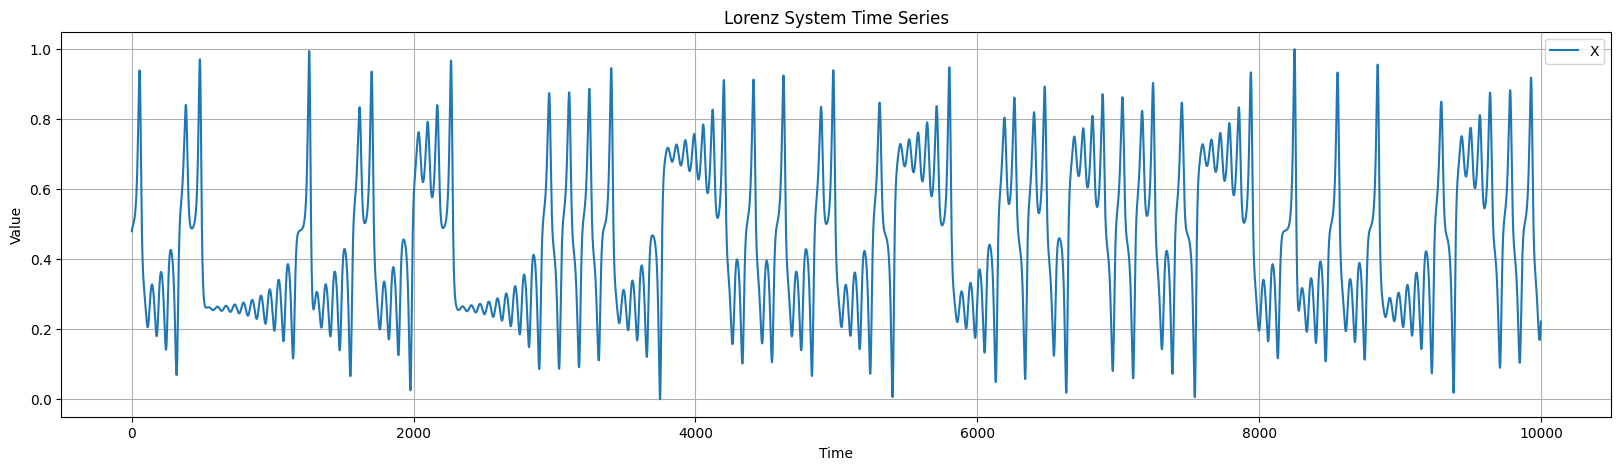

In [5]:
timeserie = x

# Normalization
timeserieNormalized = (timeserie-min(timeserie))/(max(timeserie)-min(timeserie))

plt.figure(figsize=(20, 5))
plt.plot(timeserieNormalized, label='X')
plt.title('Lorenz System Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
window = 30

X = np.zeros([len(timeserieNormalized)-window, window])
for i in range(len(timeserieNormalized)-window):
  X[i,:] = timeserieNormalized[i:i+window].T
# Vector de salida (pronostico de nuestro modelo)
y = timeserieNormalized[window:]

X = X[:,:, np.newaxis]

X.shape, y.shape


((9970, 30, 1), (9970,))

In [178]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape


((6380, 30, 1), (6380,), (1596, 30, 1), (1596,), (1994, 30, 1), (1994,))

#**Example convolutional**

##**TensorFlow**

**Input**


$$(samples, \; window \; size, 1 )$$

In [8]:
data = X_train[0][np.newaxis,:,:]
data.shape

(1, 30, 1)

**Convolutional operation**

$$(kernel \; size, \; 1, \; \; output \; dimension )$$

In [9]:
kernel_size = 5
output_dim = 100 # output_dim == D

kernel = np.ones([kernel_size, 1, output_dim], dtype=np.float32)
kernel.shape

(5, 1, 100)

In [10]:
data = tf.convert_to_tensor(data, dtype=tf.float32)
kernel = tf.convert_to_tensor(kernel)

data.shape, kernel.shape

(TensorShape([1, 30, 1]), TensorShape([5, 1, 100]))

**Kernel bandwidth $(σ)$**

$$kernel \; scale = \sqrt{ \frac{(input \; dimension).(kernel \; size)^2}{2}} $$

$kernel \; scale$ is a trainable parameter

$$σ = \frac{1}{kernel \; scale}$$


In [11]:
input_dim = 1

kernel_scale = np.sqrt((input_dim*kernel_size**2)/2.0)

scale = 1/kernel_scale

print("scale: ", kernel_scale)
print("Kernel bandwidth: ", scale)


scale:  3.5355339059327378
Kernel bandwidth:  0.282842712474619


In [12]:
kernel = tf.math.multiply(scale, kernel)
kernel.shape

TensorShape([5, 1, 100])

In [13]:
outputs = tf.nn.conv1d(data, kernel, stride=1, padding='VALID')
bias = tf.constant(np.random.rand(1), dtype=tf.float32)

outputs.shape

TensorShape([1, 26, 100])

$$z(\textbf{x}) = \sqrt{\frac{2}{D}} \left[ \cos{w_1^{⊤}\textbf{x}+b_1}, \cos{w_2^{⊤}\textbf{x}+b_2}, ̇\dots, \cos{w_D^{⊤}\textbf{x} + b_D} \right] $$

In [14]:
RFF_COS_TF = tf.math.multiply(tf.math.sqrt(2/output_dim), tf.cos(outputs))

RFF_COS_TF.shape

TensorShape([1, 26, 100])

**On the Error of Random Fourier Features**

$$
z(\textbf{x}) = \sqrt{\frac{2}{D}} \begin{bmatrix}
\sin{w_1 \textbf{x}}
\\
\cos{w_1 \textbf{x}}
\\
\vdots
\\
\sin{w_1 \textbf{x}}
\\
\cos{w_1 \textbf{x}}
\end{bmatrix}
$$

In [15]:
RFF_SIN_TF = tf.where(tf.equal(tf.math.mod(outputs, 2), 0),
                   tf.math.multiply(tf.math.sqrt(2/output_dim), tf.cos(outputs)),
                   tf.math.multiply(tf.math.sqrt(2/output_dim), tf.sin(outputs)))

RFF_SIN_TF.shape

TensorShape([1, 26, 100])

##**Pytorch**

**Input**


$$(samples, 1, \; window \; size )$$

In [16]:
data = X_train[0][np.newaxis, :, :]
data = torch.tensor(data, dtype=torch.float32).reshape(1, 1, 30)
data.shape

torch.Size([1, 1, 30])

**Convolutional operation**

$$(kernel \; size, \; 1, \; \; output \; dimension )$$

In [17]:
kernel = torch.ones((output_dim, 1, kernel_size), dtype=torch.float32)

data.shape, kernel.shape

(torch.Size([1, 1, 30]), torch.Size([100, 1, 5]))

**Kernel bandwidth $(σ)$**

$$kernel \; scale = \sqrt{ \frac{(input \; dimension).(kernel \; size)^2}{2}} $$

$kernel \; scale$ is a trainable parameter

$$σ = \frac{1}{kernel \; scale}$$


In [18]:
kernel_scale = torch.sqrt(torch.tensor((input_dim * kernel_size**2) / 2.0, dtype=torch.float32))
scale = 1 / kernel_scale

print("scale: ", kernel_scale)
print("Kernel bandwidth: ", scale)

scale:  tensor(3.5355)
Kernel bandwidth:  tensor(0.2828)


In [19]:
kernel = kernel * scale
kernel.shape

torch.Size([100, 1, 5])

In [20]:
outputs = torch.nn.functional.conv1d(data, kernel, stride=1, padding=0)
bias = torch.tensor(np.random.rand(output_dim), dtype=torch.float32)  # Bias para cada canal de salida

outputs.shape

torch.Size([1, 100, 26])

In [21]:
RFF_COS_PT = torch.sqrt(torch.tensor(2.0 / output_dim, dtype=torch.float32)) * torch.cos(outputs)

RFF_COS_PT.shape

torch.Size([1, 100, 26])

In [22]:
sqrt_term = torch.sqrt(torch.tensor(2.0 / output_dim, dtype=torch.float32))
RFF_SIN_PT = torch.where(torch.remainder(outputs, 2) == 0, sqrt_term * torch.cos(outputs), sqrt_term * torch.sin(outputs))

RFF_SIN_PT.shape

torch.Size([1, 100, 26])

#**Comparative TensorFlow and PyTorch**

In [23]:
def round_to_sigfigs(x, sigfigs=2):
    return np.round(x, sigfigs - int(np.floor(np.log10(abs(x)))) - 1)

In [24]:
tf_numpy = RFF_COS_TF.numpy()
torch_numpy = RFF_COS_PT.numpy().transpose(0, 2, 1)

tf_numpy.shape, torch_numpy.shape

((1, 26, 100), (1, 26, 100))

In [25]:
mae = np.mean(np.abs(tf_numpy - torch_numpy))           # Error absoluto medio
rmse = np.sqrt(np.mean((tf_numpy - torch_numpy) ** 2))  # Error cuadrático medio

# Mostrar resultados con dos cifras significativas
print(f"Mean Absolute Error (MAE): {round_to_sigfigs(mae, sigfigs=2)}")
print(f"Root Mean Square Error (RMSE): {round_to_sigfigs(rmse, sigfigs=2)}")

Mean Absolute Error (MAE): 6.299999966152825e-10
Root Mean Square Error (RMSE): 2.1999999599842113e-09


#**Custom Layer in PyTorch**

##**Layer**

In [42]:
def _get_random_features_initializer(initializer, shape, seed=None):
    # Esta función debe retornar un arreglo numpy con la inicialización deseada.
    # Por ejemplo, si el initializer es 'gaussian':
    if seed is not None:
        np.random.seed(seed)
    if initializer == 'gaussian':
        # Por ejemplo, inicialización gaussiana estándar
        return np.random.randn(*shape)
    elif initializer == 'laplacian':
        # Por ejemplo, inicialización con distribución Laplaciana
        return np.random.laplace(loc=0.0, scale=1.0, size=shape)
    else:
        raise ValueError(f'Unsupported initializer {initializer}')


In [27]:
data.shape, kernel.shape

(torch.Size([1, 1, 30]), torch.Size([100, 1, 5]))

In [122]:
class Conv1dRFF_PT(nn.Module):
    def __init__(self, output_dim, kernel_size=3, scale=None, padding='VALID', normalization=True,
                 function=True, trainable_scale=False, trainable_W=False, seed=None, kernel='gaussian', **kwargs):
        super(Conv1dRFF_PT, self).__init__()
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.scale = scale
        # Reemplazamos 'VALID' por 0 para no padding
        self.padding = 0 if padding == 'VALID' else padding
        self.normalization = normalization
        self.function = function
        self.trainable_scale = trainable_scale
        self.trainable_W = trainable_W
        self.seed = seed
        self.initializer = kernel

        # Parámetros se inicializarán perezosamente la primera vez que se llame a forward
        self.kernel = None
        self.bias = None
        self.kernel_scale = None

    def forward(self, inputs):
        # Si los parámetros no están inicializados, los inicializamos ahora
        if self.kernel is None:
            input_shape = inputs.shape
            input_dim = input_shape[1]

            kernel_initializer = _get_random_features_initializer(
                self.initializer,
                shape=(self.output_dim, input_dim, self.kernel_size),
                seed=self.seed
            )

            self.kernel = nn.Parameter(torch.tensor(kernel_initializer, dtype=torch.float32),
                                       requires_grad=self.trainable_W)

            self.bias = nn.Parameter(torch.empty(self.output_dim).uniform_(0.0, 2 * np.pi),
                                     requires_grad=self.trainable_W)

            # Set scale if not provided
            if self.scale is None:
                if self.initializer == 'gaussian':
                    self.scale = np.sqrt((input_dim * (self.kernel_size ** 2)) / 2.0)
                elif self.initializer == 'laplacian':
                    self.scale = 1.0
                else:
                    raise ValueError(f'Unsupported kernel initializer {self.initializer}')

            self.kernel_scale = nn.Parameter(torch.tensor([self.scale], dtype=torch.float32),
                                             requires_grad=self.trainable_scale)

        scale = 1.0 / self.kernel_scale
        kernel = scale * self.kernel

        outputs = F.conv1d(inputs, kernel, bias=self.bias, stride=1, padding=self.padding)

        #Si normalization es True:
        if self.normalization:
            # Crear el factor de escala sqrt(2 / output_dim)
            scale_factor = torch.sqrt(torch.tensor(2.0 / self.output_dim, dtype=outputs.dtype, device=outputs.device))

            if self.function:
                # outputs = scale_factor * cos(outputs)
                outputs = scale_factor * torch.cos(outputs)
            else:
                # condition = (outputs % 2 == 0)
                condition = (outputs % 2 == 0)
                # outputs = where(condition, scale_factor * cos(outputs), scale_factor * sin(outputs))
                outputs = torch.where(condition,
                                      scale_factor * torch.cos(outputs),
                                      scale_factor * torch.sin(outputs))
        else:
            # Si normalization es False
            if self.function:
                # outputs = cos(outputs)
                outputs = torch.cos(outputs)
            else:
                # condition = (outputs % 2 == 0)
                condition = (outputs % 2 == 0)
                # outputs = where(condition, cos(outputs), sin(outputs))
                outputs = torch.where(condition, torch.cos(outputs), torch.sin(outputs))

        return outputs



In [119]:
output_dim, kernel_size, data.shape

(100, 5, torch.Size([1, 1, 30]))

In [123]:
model_PT = Conv1dRFF_PT(
    output_dim=output_dim,
    kernel_size=kernel_size,
    seed=42,
    kernel='gaussian',
    padding='VALID',
    normalization=True,
    function=True
)

h = model_PT(data)
h.shape

torch.Size([1, 100, 26])

##**Example**

In [179]:
X_train = X_train.transpose(0, 2, 1)
X_valid = X_valid.transpose(0, 2, 1)
X_test  = X_test.transpose(0, 2, 1)

y_train = y_train.reshape(-1, 1)
y_val   = y_valid.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)


In [180]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_valid, dtype=torch.float32)
Y_val_t   = torch.tensor(y_valid, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
Y_test_t  = torch.tensor(y_test, dtype=torch.float32)

In [181]:
class ForecastModel(nn.Module):
    def __init__(self, output_dim=100, kernel_size=5, horizon=1):
        super(ForecastModel, self).__init__()
        self.conv_rff = Conv1dRFF_PT(output_dim=output_dim, kernel_size=kernel_size,
                                     seed=42, kernel='gaussian', padding='VALID',
                                     normalization=True, function=True)
        # Calcular la dimensión de salida tras la conv:
        # length_out = input_window - kernel_size + 1 = 30 - 5 + 1 = 26 (con padding=0, stride=1)
        self.flatten = nn.Flatten()
        # La capa lineal final para predecir horizon=1 valor
        self.fc = nn.Linear(output_dim*26, horizon)

    def forward(self, x):
        x = self.conv_rff(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [182]:
model = ForecastModel(output_dim=100, kernel_size=5, horizon=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [183]:
train_losses = []
val_losses = []

epochs = 200
batch_size = 32

for epoch in range(epochs):
    model.train()
    permutation = np.random.permutation(len(X_train_t))
    epoch_train_loss = 0.0

    for i in range(0, len(X_train_t), batch_size):
        idx = permutation[i:i+batch_size]
        X_batch = X_train_t[idx]
        Y_batch = Y_train_t[idx]

        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, Y_batch)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()*len(X_batch)

    epoch_train_loss /= len(X_train_t)

    # Validación
    model.eval()
    with torch.no_grad():
        pred_val = model(X_val_t)
        val_loss = criterion(pred_val, Y_val_t).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1596])) that is different to the input size (torch.Size([1596, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/200, Train Loss: 0.0030, Val Loss: 0.0821
Epoch 20/200, Train Loss: 0.0011, Val Loss: 0.0854
Epoch 30/200, Train Loss: 0.0007, Val Loss: 0.0867
Epoch 40/200, Train Loss: 0.0005, Val Loss: 0.0874
Epoch 50/200, Train Loss: 0.0003, Val Loss: 0.0874
Epoch 60/200, Train Loss: 0.0002, Val Loss: 0.0880
Epoch 70/200, Train Loss: 0.0002, Val Loss: 0.0875
Epoch 80/200, Train Loss: 0.0001, Val Loss: 0.0881
Epoch 90/200, Train Loss: 0.0001, Val Loss: 0.0882
Epoch 100/200, Train Loss: 0.0001, Val Loss: 0.0880
Epoch 110/200, Train Loss: 0.0001, Val Loss: 0.0884
Epoch 120/200, Train Loss: 0.0001, Val Loss: 0.0882
Epoch 130/200, Train Loss: 0.0001, Val Loss: 0.0883
Epoch 140/200, Train Loss: 0.0001, Val Loss: 0.0880
Epoch 150/200, Train Loss: 0.0001, Val Loss: 0.0879
Epoch 160/200, Train Loss: 0.0001, Val Loss: 0.0883
Epoch 170/200, Train Loss: 0.0001, Val Loss: 0.0881
Epoch 180/200, Train Loss: 0.0001, Val Loss: 0.0880
Epoch 190/200, Train Loss: 0.0000, Val Loss: 0.0885
Epoch 200/200, Train 

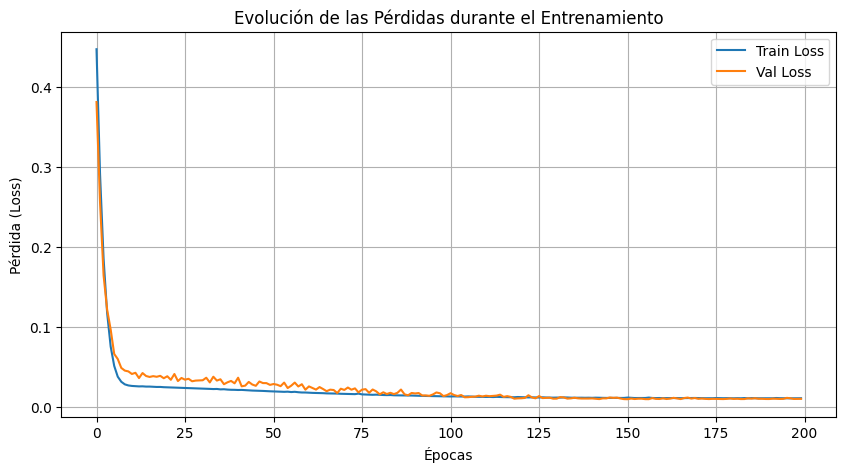

In [166]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Evolución de las Pérdidas durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.grid(True)
plt.legend()
plt.show()

In [187]:
model.eval()
with torch.no_grad():
    pred_test = model(X_test_t)

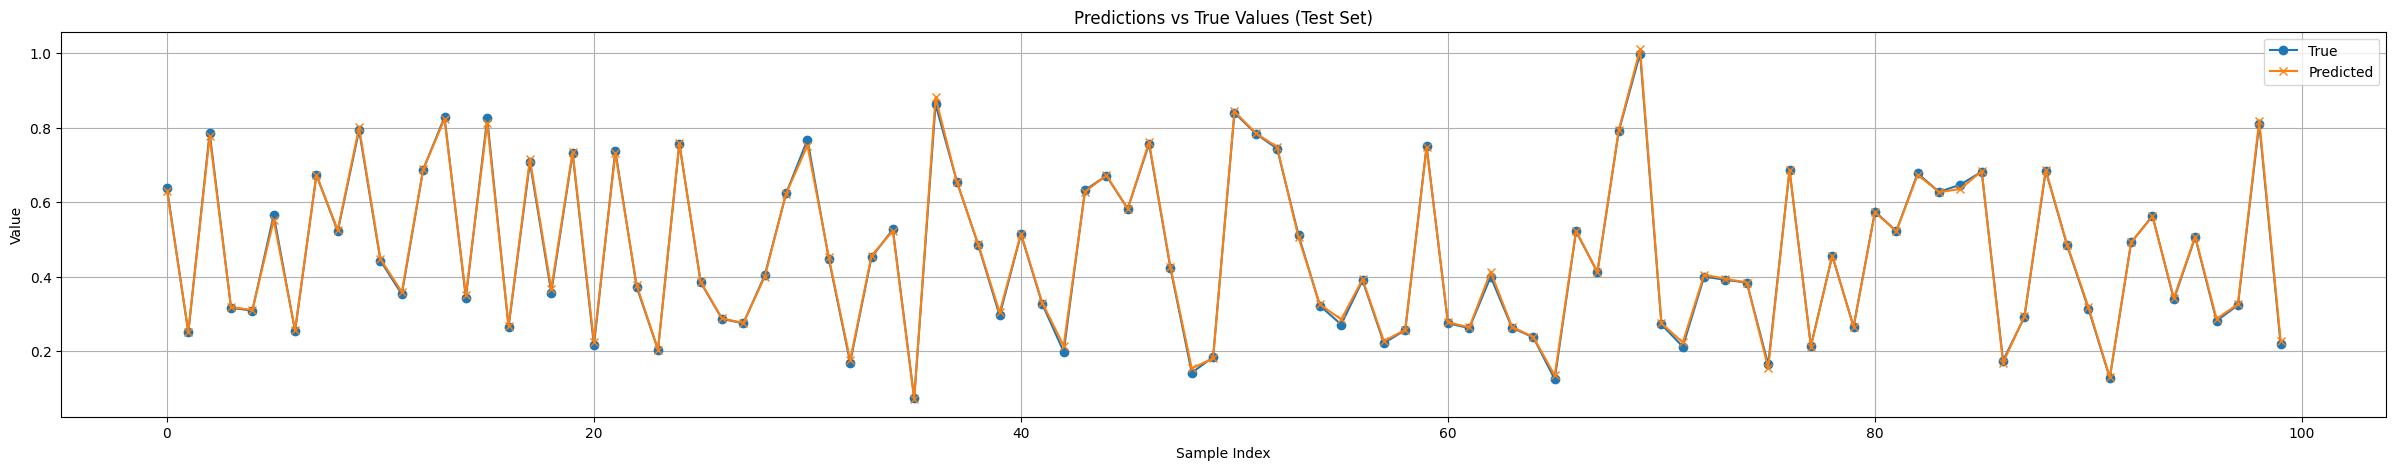

In [190]:
true_values = Y_test_t.detach().numpy()
pred_values = pred_test.detach().numpy()

plt.figure(figsize=(30,5))
plt.plot(true_values[0:100], label='True', marker='o')
plt.plot(pred_values[0:100], label='Predicted', marker='x')
plt.title('Predictions vs True Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [192]:
pred = pred_test.detach().numpy().flatten()
true = Y_test_t.detach().numpy().flatten()

In [198]:
mse = mean_squared_error(true, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true, pred)
mae_norm = mae / np.mean(np.abs(true))
mape = mean_absolute_percentage_error(true, pred) * 100
r2 = r2_score(true, pred)

In [199]:
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAE Normalizado:", mae_norm)
print("MAPE (%):", mape)
print("R²:", r2)

MSE: 3.975151e-05
RMSE: 0.0063048797
MAE: 0.0044081938
MAE Normalizado: 0.009839568
MAPE (%): 1.8717451021075249
R²: 0.9991222620010376
